In [62]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [63]:
# ------------------------------------------------
# 
# Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

In [227]:
# -----------
# Implement a PID controller.
# The steering angle should be set by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
#
# where the integrated crosstrack error (int_CTE) is
# the sum of all the previous crosstrack errors.
# This term works to cancel out steering drift.
#
class PID(object):
    def __init__(self, tau):
        self.cte_prev = 0.0  # previous cte
        self.cte_tot  = 0.0  # cumulative cte
        self.tau = tau

    def control(self, cte, delta_t=1.0):
        cte_diff = (cte - self.cte_prev) / delta_t
        self.cte_tot += cte * delta_t
        self.cte_prev = cte
        return -self.tau[0] * cte - self.tau[1] * cte_diff - self.tau[2] * self.cte_tot

In [ ]:
from matplotlib.legend_handler import HandlerLine2D

def make_robot(drift=0.0):
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0, -1, 0)
    robot.set_steering_drift(drift / 180 * np.pi)
    return robot

def run(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    
    x_trajectory.append(robot.x)
    y_trajectory.append(robot.y)
    
    pid = PID(tau)
    err = 0.0
    cte = robot.y
    
    for i in range(2*n):
        steer = pid.control(cte, delta_t=0.05)
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        cte = robot.y
        #print(robot, steer)
        if i >= n:
            err += cte**2
    return x_trajectory, y_trajectory, err / n    


# Make this tolerance bigger if you are timing out!
def twiddle(tolerance=0.2, drift=0.0): 
    p = [0, 0, 0]  # parameters
    dp = [1, 1, 1] # change vector
    robot = make_robot(drift)
    x_trajectory, y_trajectory, best_err = run(robot, p)
    
    n = 0
    while sum(dp) > tolerance:
        
        #print("Iteration {}, best error = {}".format(n, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            robot = make_robot(drift)
            x_trajectory, y_trajectory, err = run(robot, p)

            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                robot = make_robot(drift)
                x_trajectory, y_trajectory, err = run(robot, p)

                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        n += 1 
    
    print("Twiddle iterations: ", n)
    return p, best_err

Twiddle iterations:  91
Twiddle parameters:  [2.085759606101585, 0.4154148999999998, 5.771390084538708]


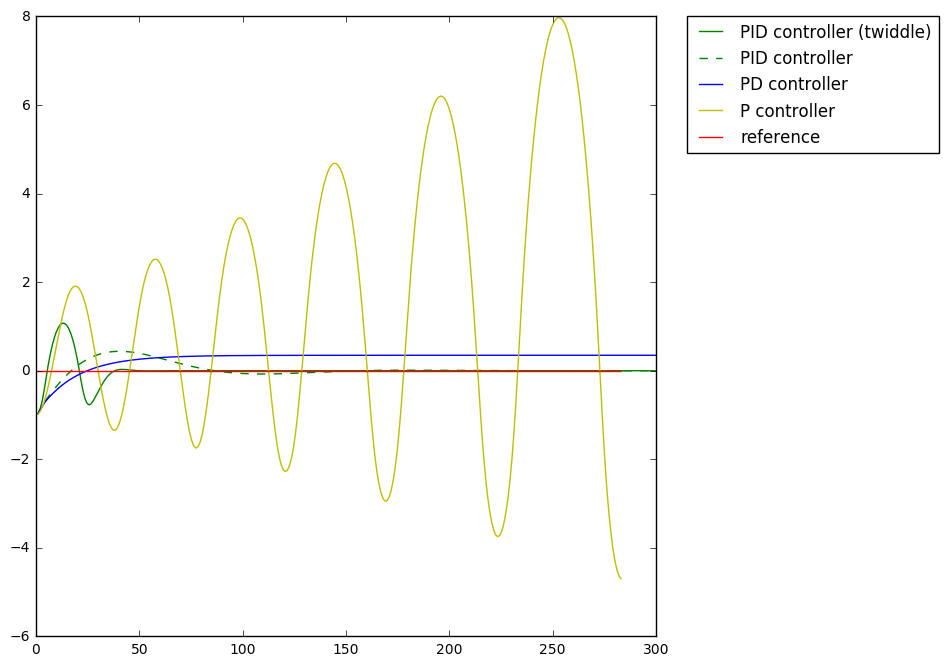

In [279]:
n = 150
#drift = 0.0203695458989
drift = 10.0

tau, err = twiddle(tolerance=0.001, drift=drift)
print("Twiddle parameters: ", tau)
robot = make_robot(drift)
twiddle_x_trajectory, twiddle_y_trajectory, err = run(robot, tau, n=n)

tau = [.5, .5, .5]
#tau = [2.085759606101585, 0.4154148999999998, 5.771390084538708]
robot = make_robot(drift)
pid_x_trajectory, pid_y_trajectory, err = run(robot, tau, n=n)

tau = [.5, .5, .0]
robot = make_robot(drift)
pd_x_trajectory, pd_y_trajectory, err = run(robot, tau, n=n)

tau = [.5, .0, .0]
robot = make_robot(drift)
p_x_trajectory, p_y_trajectory, err = run(robot, tau, n=n)

n = len(pid_x_trajectory)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
line0, = ax1.plot(twiddle_x_trajectory, twiddle_y_trajectory, 'g', label='PID controller (twiddle)')
line1, = ax1.plot(pid_x_trajectory, pid_y_trajectory, 'g', linestyle='dashed', label='PID controller')
line2, = ax1.plot(pd_x_trajectory, pd_y_trajectory, 'b', label='PD controller')
line3, = ax1.plot(p_x_trajectory, p_y_trajectory, 'y', label='P controller')
line4, = ax1.plot(p_x_trajectory, np.zeros(n), 'r', label='reference')

ax1.legend(handler_map={line1: HandlerLine2D(numpoints=4)}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show();